# Tutorial 02e PS estimation correlation

In [1]:
import numpy as np
import healpy as hp
import matplotlib
import abspy as ap
from scipy import stats
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


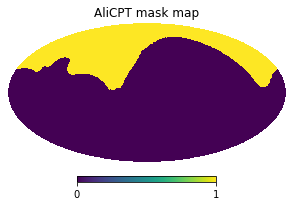

In [2]:
NSIDE = 128

# CMB PS
cmb_cl = hp.read_cl('./data/camb_cls.fits')
ell = np.arange(cmb_cl.shape[1])
# single CMB realization
mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True)
# variance map
vmap = hp.read_map('./data/alivar_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
# mask map
mask = hp.read_map('./data/ali_mask.fits',dtype=np.float32,verbose=False)
#mapcmb[:,mask<1.] = 0.
#vmap[:,mask<1.] = 0.

fig = matplotlib.pyplot.figure(figsize=(5,5))
gs = matplotlib.gridspec.GridSpec(5, 5)
fig.add_subplot(gs[0:5, 0:5])
hp.mollview(mask,title='AliCPT mask map',hold=True)

In [3]:
# calculate binned CMB band-power from input Cl
est = ap.pstimator(nside=NSIDE,mask=mask.reshape(1,-1),aposcale=6.0,psbin=40)

cmb_dl = np.zeros((4,len(est.modes)))
cmb_dl[0] = est.modes
for i in range(len(est.modes)):
    lrange = np.array(est._b.get_ell_list(i))
    factor = 0.5*lrange*(lrange+1)/np.pi
    w = np.array(est._b.get_weight_list(i))
    for j in range(3):
        cmb_dl[j+1,i] = np.sum(w*cmb_cl[j,lrange]*factor)

### single PS estimation without noise

In [13]:
RESAMP = 50

bp_t = np.zeros((RESAMP,len(cmb_dl[0])))
bp_e = np.zeros_like(bp_t)
bp_b = np.zeros_like(bp_t)

for i in range(RESAMP):
    # realize CMB map without noise
    tmp = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=False)
    bp_t[i] = est.auto_t(tmp[0].reshape(1,-1))[1]
    eb = est.auto_eb(tmp[1:].reshape(2,-1))
    bp_e[i] = eb[1]
    bp_b[i] = eb[2]

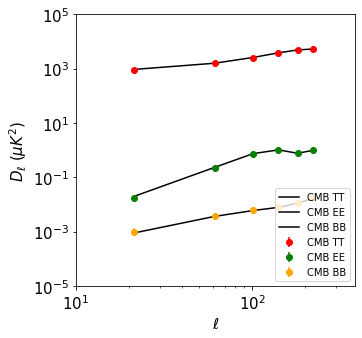

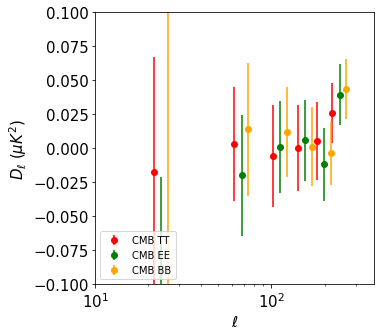

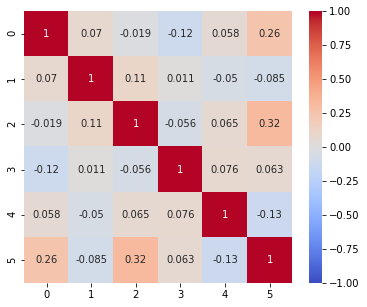

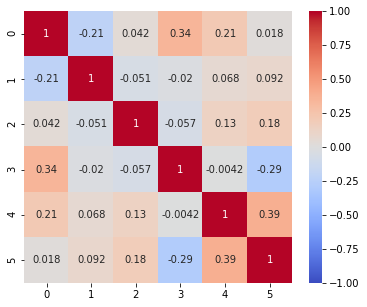

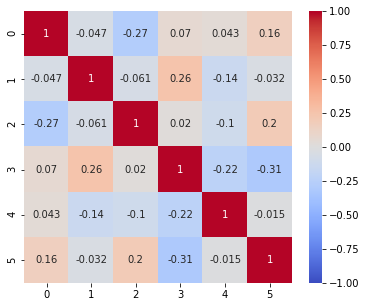

In [14]:
fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

ax.errorbar(cmb_dl[0],np.mean(bp_t,axis=0),np.std(bp_t,axis=0),
            color='red',fmt='o',label=r'CMB TT')
ax.errorbar(cmb_dl[0],np.mean(bp_e,axis=0),np.std(bp_e,axis=0),
            color='green',fmt='o',label=r'CMB EE')
ax.errorbar(cmb_dl[0],np.mean(bp_b,axis=0),np.std(bp_b,axis=0),
            color='orange',fmt='o',label=r'CMB BB')

ax.plot(cmb_dl[0],cmb_dl[1],
        color='k',label=r'CMB TT')
ax.plot(cmb_dl[0],cmb_dl[2],
        color='k',label=r'CMB EE')
ax.plot(cmb_dl[0],cmb_dl[3],
        color='k',label=r'CMB BB')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=4)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-5,1.e5))
ax.set_xlim((10,3*NSIDE))


fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

ax.errorbar(cmb_dl[0],(np.mean(bp_t,axis=0)-cmb_dl[1])/cmb_dl[1],
            np.std(bp_t,axis=0)/cmb_dl[1],
            color='red',fmt='o',label=r'CMB TT')
ax.errorbar(cmb_dl[0]*1.1,(np.mean(bp_e,axis=0)-cmb_dl[2])/cmb_dl[2],
            np.std(bp_e,axis=0)/cmb_dl[2],
            color='green',fmt='o',label=r'CMB EE')
ax.errorbar(cmb_dl[0]*1.2,(np.mean(bp_b,axis=0)-cmb_dl[3])/cmb_dl[3],
            np.std(bp_b,axis=0)/cmb_dl[3],
            color='orange',fmt='o',label=r'CMB BB')

ax.set_xscale('log')
ax.legend(loc=3)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim(-0.1,0.1)
ax.set_xlim((10,3*NSIDE))


cov_t, pval = stats.spearmanr(bp_t,axis=0)
cov_e, pval = stats.spearmanr(bp_e,axis=0)
cov_b, pval = stats.spearmanr(bp_b,axis=0)

fig,ax = matplotlib.pyplot.subplots(figsize=(6,5))
sns.heatmap(cov_t,cmap='coolwarm',vmin=-1,vmax=1,annot=True,ax=ax)

fig,ax = matplotlib.pyplot.subplots(figsize=(6,5))
sns.heatmap(cov_e,cmap='coolwarm',vmin=-1,vmax=1,annot=True,ax=ax)

fig,ax = matplotlib.pyplot.subplots(figsize=(6,5))
sns.heatmap(cov_b,cmap='coolwarm',vmin=-1,vmax=1,annot=True,ax=ax)

- Pearson's correlation coefficients

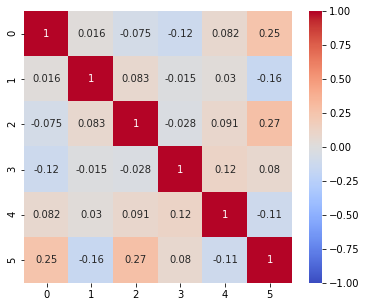

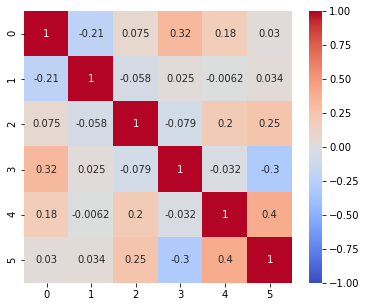

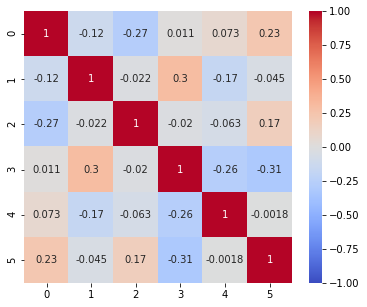

In [20]:
cov_t = np.cov(np.transpose(bp_t))
cov_e = np.cov(np.transpose(bp_e))
cov_b = np.cov(np.transpose(bp_b))

fig,ax = matplotlib.pyplot.subplots(figsize=(6,5))
sns.heatmap(cov_t/np.sqrt(np.tensordot(np.diag(cov_t),np.diag(cov_t),axes=0)),
            cmap='coolwarm',vmin=-1,vmax=1,annot=True,ax=ax)

fig,ax = matplotlib.pyplot.subplots(figsize=(6,5))
sns.heatmap(cov_e/np.sqrt(np.tensordot(np.diag(cov_e),np.diag(cov_e),axes=0)),
            cmap='coolwarm',vmin=-1,vmax=1,annot=True,ax=ax)

fig,ax = matplotlib.pyplot.subplots(figsize=(6,5))
sns.heatmap(cov_b/np.sqrt(np.tensordot(np.diag(cov_b),np.diag(cov_b),axes=0)),
            cmap='coolwarm',vmin=-1,vmax=1,annot=True,ax=ax)

### PS estimation with noise

In [6]:
bp_t = np.zeros((RESAMP,len(cmb_dl[0])))
bp_e = np.zeros_like(bp_t)
bp_b = np.zeros_like(bp_t)

np_t = np.zeros_like(bp_t)
np_e = np.zeros_like(bp_t)
np_b = np.zeros_like(bp_t)

for i in range(RESAMP):
    # realize CMB map with noise
    noise = np.random.normal(size=mapcmb.shape)*np.sqrt(vmap)
    tmp = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=False) + noise
    bp_t[i] = est.auto_t(tmp[0].reshape(1,-1))[1]
    eb = est.auto_eb(tmp[1:].reshape(2,-1))
    bp_e[i] = eb[1]
    bp_b[i] = eb[2]
    np_t[i] = est.auto_t(noise[0].reshape(1,-1))[1]
    eb = est.auto_eb(noise[1:].reshape(2,-1))
    np_e[i] = eb[1]
    np_b[i] = eb[2]

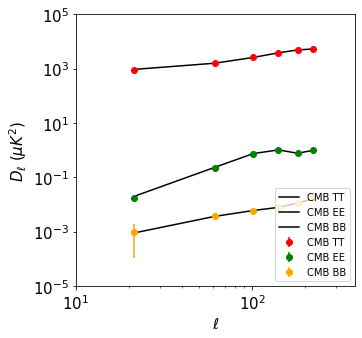

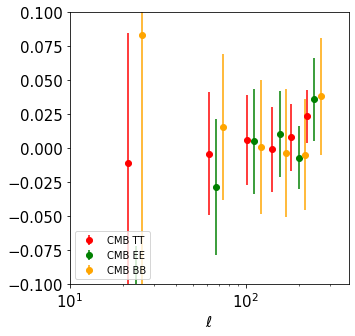

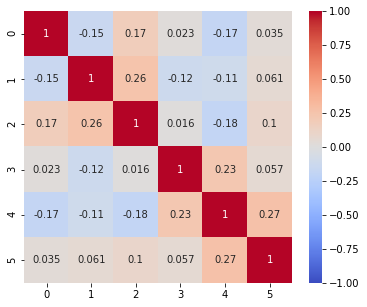

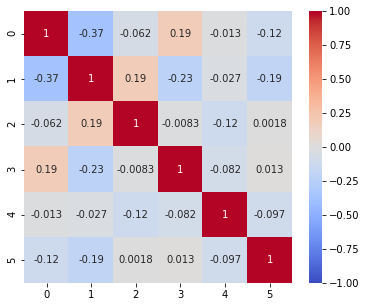

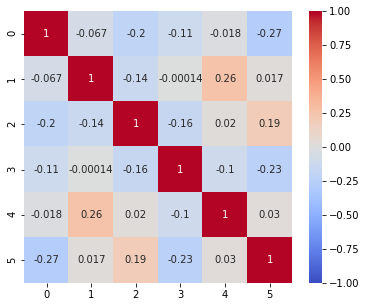

In [7]:
fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

ax.errorbar(cmb_dl[0],np.mean(bp_t,axis=0)-np.mean(np_t,axis=0),np.std(bp_t,axis=0),
            color='red',fmt='o',label=r'CMB TT')
ax.errorbar(cmb_dl[0],np.mean(bp_e,axis=0)-np.mean(np_e,axis=0),np.std(bp_e,axis=0),
            color='green',fmt='o',label=r'CMB EE')
ax.errorbar(cmb_dl[0],np.mean(bp_b,axis=0)-np.mean(np_b,axis=0),np.std(bp_b,axis=0),
            color='orange',fmt='o',label=r'CMB BB')

ax.plot(cmb_dl[0],cmb_dl[1],
        color='k',label=r'CMB TT')
ax.plot(cmb_dl[0],cmb_dl[2],
        color='k',label=r'CMB EE')
ax.plot(cmb_dl[0],cmb_dl[3],
        color='k',label=r'CMB BB')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=4)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-5,1.e5))
ax.set_xlim((10,3*NSIDE))


fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

ax.errorbar(cmb_dl[0],(np.mean(bp_t,axis=0)-np.mean(np_t,axis=0)-cmb_dl[1])/cmb_dl[1],
            np.std(bp_t,axis=0)/cmb_dl[1],
            color='red',fmt='o',label=r'CMB TT')
ax.errorbar(cmb_dl[0]*1.1,(np.mean(bp_e,axis=0)-np.mean(np_e,axis=0)-cmb_dl[2])/cmb_dl[2],
            np.std(bp_e,axis=0)/cmb_dl[2],
            color='green',fmt='o',label=r'CMB EE')
ax.errorbar(cmb_dl[0]*1.2,(np.mean(bp_b,axis=0)-np.mean(np_b,axis=0)-cmb_dl[3])/cmb_dl[3],
            np.std(bp_b,axis=0)/cmb_dl[3],
            color='orange',fmt='o',label=r'CMB BB')

ax.set_xscale('log')
ax.legend(loc=3)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim(-0.1,0.1)
ax.set_xlim((10,3*NSIDE))


cov_t, pval = stats.spearmanr(bp_t,axis=0)
cov_e, pval = stats.spearmanr(bp_e,axis=0)
cov_b, pval = stats.spearmanr(bp_b,axis=0)

fig,ax = matplotlib.pyplot.subplots(figsize=(6,5))
sns.heatmap(cov_t,cmap='coolwarm',vmin=-1,vmax=1,annot=True,ax=ax)

fig,ax = matplotlib.pyplot.subplots(figsize=(6,5))
sns.heatmap(cov_e,cmap='coolwarm',vmin=-1,vmax=1,annot=True,ax=ax)

fig,ax = matplotlib.pyplot.subplots(figsize=(6,5))
sns.heatmap(cov_b,cmap='coolwarm',vmin=-1,vmax=1,annot=True,ax=ax)

### single singal with noise

In [8]:
bp_t = np.zeros((RESAMP,len(cmb_dl[0])))
bp_e = np.zeros_like(bp_t)
bp_b = np.zeros_like(bp_t)

np_t = np.zeros_like(bp_t)
np_e = np.zeros_like(bp_t)
np_b = np.zeros_like(bp_t)

signal = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=False)
for i in range(RESAMP):
    # realize CMB map with noise
    noise = np.random.normal(size=mapcmb.shape)*np.sqrt(vmap)
    tmp = signal + noise
    bp_t[i] = est.auto_t(tmp[0].reshape(1,-1))[1]
    eb = est.auto_eb(tmp[1:].reshape(2,-1))
    bp_e[i] = eb[1]
    bp_b[i] = eb[2]
    np_t[i] = est.auto_t(noise[0].reshape(1,-1))[1]
    eb = est.auto_eb(noise[1:].reshape(2,-1))
    np_e[i] = eb[1]
    np_b[i] = eb[2]

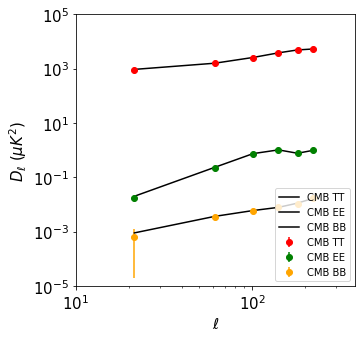

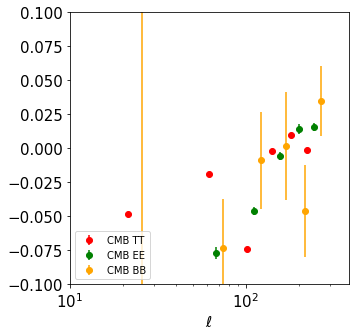

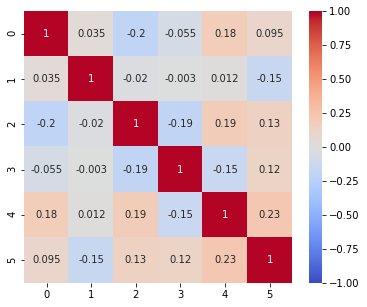

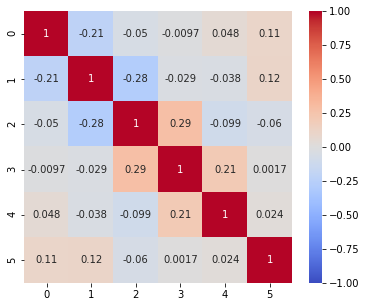

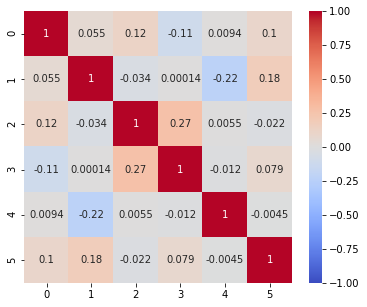

In [9]:
fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

ax.errorbar(cmb_dl[0],np.mean(bp_t,axis=0)-np.mean(np_t,axis=0),np.std(bp_t,axis=0),
            color='red',fmt='o',label=r'CMB TT')
ax.errorbar(cmb_dl[0],np.mean(bp_e,axis=0)-np.mean(np_e,axis=0),np.std(bp_e,axis=0),
            color='green',fmt='o',label=r'CMB EE')
ax.errorbar(cmb_dl[0],np.mean(bp_b,axis=0)-np.mean(np_b,axis=0),np.std(bp_b,axis=0),
            color='orange',fmt='o',label=r'CMB BB')

ax.plot(cmb_dl[0],cmb_dl[1],
        color='k',label=r'CMB TT')
ax.plot(cmb_dl[0],cmb_dl[2],
        color='k',label=r'CMB EE')
ax.plot(cmb_dl[0],cmb_dl[3],
        color='k',label=r'CMB BB')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=4)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-5,1.e5))
ax.set_xlim((10,3*NSIDE))


fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

ax.errorbar(cmb_dl[0],(np.mean(bp_t,axis=0)-np.mean(np_t,axis=0)-cmb_dl[1])/cmb_dl[1],
            np.std(bp_t,axis=0)/cmb_dl[1],
            color='red',fmt='o',label=r'CMB TT')
ax.errorbar(cmb_dl[0]*1.1,(np.mean(bp_e,axis=0)-np.mean(np_e,axis=0)-cmb_dl[2])/cmb_dl[2],
            np.std(bp_e,axis=0)/cmb_dl[2],
            color='green',fmt='o',label=r'CMB EE')
ax.errorbar(cmb_dl[0]*1.2,(np.mean(bp_b,axis=0)-np.mean(np_b,axis=0)-cmb_dl[3])/cmb_dl[3],
            np.std(bp_b,axis=0)/cmb_dl[3],
            color='orange',fmt='o',label=r'CMB BB')

ax.set_xscale('log')
ax.legend(loc=3)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim(-0.1,0.1)
ax.set_xlim((10,3*NSIDE))


cov_t, pval = stats.spearmanr(bp_t,axis=0)
cov_e, pval = stats.spearmanr(bp_e,axis=0)
cov_b, pval = stats.spearmanr(bp_b,axis=0)

fig,ax = matplotlib.pyplot.subplots(figsize=(6,5))
sns.heatmap(cov_t,cmap='coolwarm',vmin=-1,vmax=1,annot=True,ax=ax)

fig,ax = matplotlib.pyplot.subplots(figsize=(6,5))
sns.heatmap(cov_e,cmap='coolwarm',vmin=-1,vmax=1,annot=True,ax=ax)

fig,ax = matplotlib.pyplot.subplots(figsize=(6,5))
sns.heatmap(cov_b,cmap='coolwarm',vmin=-1,vmax=1,annot=True,ax=ax)

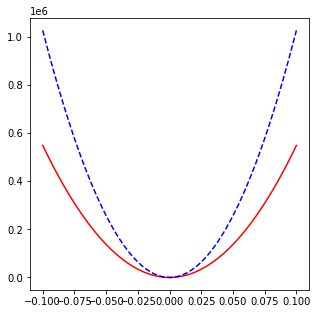

In [10]:
x = np.linspace(-0.1,0.1,100)

cov_t = np.cov(np.transpose(bp_b))
cov_t_diag = np.diag(np.diag(cov_t))

y_t_diag = np.zeros_like(x)
y_t = np.zeros_like(x)

for i in range(len(x)):
    diff = np.ones(cov_t.shape[0])*x[i]
    y_t[i] = 0.5*np.vdot(diff,np.linalg.solve(cov_t,diff))
    y_t_diag[i] = np.vdot(diff,np.linalg.solve(cov_t_diag,diff))
    
fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))
ax.plot(x,y_t,'r')
ax.plot(x,y_t_diag,'b--')

### PS estimation with healpy

In [11]:
bp_t = np.zeros((RESAMP,3*NSIDE))
bp_e = np.zeros_like(bp_t)
bp_b = np.zeros_like(bp_t)

np_t = np.zeros_like(bp_t)
np_e = np.zeros_like(bp_t)
np_b = np.zeros_like(bp_t)

fsky = np.sum(mask)/len(mask)
print ('fsky: %f' % fsky)

for i in range(RESAMP):
    # realize CMB map with noise
    noise = np.random.normal(size=mapcmb.shape)*np.sqrt(vmap)
    tmp = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=False) + noise
    tmp[:,mask<1.] = 0.
    noise[:,mask<1.] = 0.
    cls = hp.anafast(tmp)[:3]
    bp_t[i] = cls[0]/fsky
    bp_e[i] = cls[1]/fsky
    bp_b[i] = cls[2]/fsky
    cls = hp.anafast(noise)[:3]
    np_t[i] = cls[0]/fsky
    np_e[i] = cls[1]/fsky
    np_b[i] = cls[2]/fsky

fsky: 0.234762


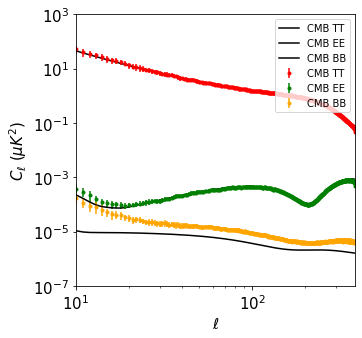

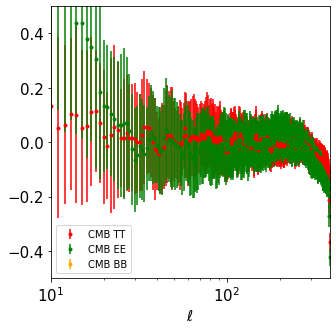

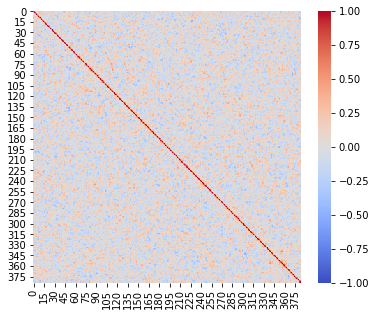

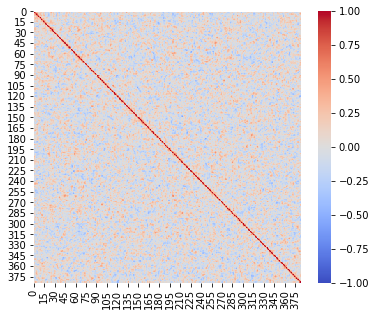

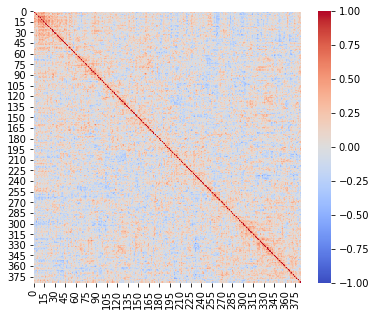

In [12]:
ell = ell[:3*NSIDE]
cmb_cl = cmb_cl[:,:3*NSIDE]

fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

ax.errorbar(ell,np.mean(bp_t,axis=0)-np.mean(np_t,axis=0),np.std(bp_t,axis=0),
            color='red',fmt='.',label=r'CMB TT')
ax.errorbar(ell,np.mean(bp_e,axis=0)-np.mean(np_e,axis=0),np.std(bp_e,axis=0),
            color='green',fmt='.',label=r'CMB EE')
ax.errorbar(ell,np.mean(bp_b,axis=0)-np.mean(np_b,axis=0),np.std(bp_b,axis=0),
            color='orange',fmt='.',label=r'CMB BB')

ax.plot(ell,cmb_cl[0],
        color='k',label=r'CMB TT')
ax.plot(ell,cmb_cl[1],
        color='k',label=r'CMB EE')
ax.plot(ell,cmb_cl[2],
        color='k',label=r'CMB BB')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=1)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$C_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-7,1.e3))
ax.set_xlim((10,3*NSIDE))


fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

ax.errorbar(ell,(np.mean(bp_t,axis=0)-np.mean(np_t,axis=0)-cmb_cl[0])/cmb_cl[0],
            np.std(bp_t,axis=0)/cmb_cl[0],
            color='red',fmt='.',label=r'CMB TT')
ax.errorbar(ell,(np.mean(bp_e,axis=0)-np.mean(np_e,axis=0)-cmb_cl[1])/cmb_cl[1],
            np.std(bp_e,axis=0)/cmb_cl[1],
            color='green',fmt='.',label=r'CMB EE')
ax.errorbar(ell,(np.mean(bp_b,axis=0)-np.mean(np_b,axis=0)-cmb_cl[2])/cmb_cl[2],
            np.std(bp_b,axis=0)/cmb_cl[2],
            color='orange',fmt='.',label=r'CMB BB')

ax.set_xscale('log')
ax.legend(loc=3)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim(-0.5,0.5)
ax.set_xlim((10,3*NSIDE))


cov_t, pval = stats.spearmanr(bp_t,axis=0)
cov_e, pval = stats.spearmanr(bp_e,axis=0)
cov_b, pval = stats.spearmanr(bp_b,axis=0)

fig,ax = matplotlib.pyplot.subplots(figsize=(6,5))
sns.heatmap(cov_t,cmap='coolwarm',vmin=-1,vmax=1,ax=ax)

fig,ax = matplotlib.pyplot.subplots(figsize=(6,5))
sns.heatmap(cov_e,cmap='coolwarm',vmin=-1,vmax=1,ax=ax)

fig,ax = matplotlib.pyplot.subplots(figsize=(6,5))
sns.heatmap(cov_b,cmap='coolwarm',vmin=-1,vmax=1,ax=ax)

end